In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csc_matrix as csc
import pandas as pd
pd.options.display.float_format = '{:,.6f}'.format
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    log_loss,
    confusion_matrix
)
from sklearn.preprocessing import minmax_scale
import time
import matplotlib.pyplot as plt
FONT_SIZE = 24
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
%config InlineBackend.figure_format ='retina'
import itertools
from constants import (SEED, EPSILON, EVENT_THRESHOLD, DEFAULT_K, DEFAULT_THRESHOLD,  UX_CONSTANTS, LOG_DIR, 
                       DATA_DIR, TEST_DATA_PATH, DATA_OCT, DATA_NOV, USECOLS, USER, ITEM, RATING, PREDICTION)
from utilities.ms_evaluation import (rmse, auc, logloss, precision_at_k, recall_at_k, ndcg_at_k, map_at_k, mae, rsquared, exp_var)

In [2]:
# NAME = r'BasicMatrixFactorization'
NAME = r'AdamUXML' 
Y_HAT_PATH = DATA_DIR+r'/'+NAME+r'-y_hat.npz'
# Y_HAT_PATH = DATA_DIR+r'BasicMatrixFactorization-y_hat-v12.npz'
TEST_RESULTS_PATH = LOG_DIR+'\\'+NAME+'\\test-results.csv'
SKL = "(calculated using sklearn.metrics on non-zero values of sparse matrices)"
SPA = "(calculated using CSC sparse matrix operations)"
MSE = "(calculated using the Microsoft Evaluation method)"
ux_constants = pd.Series(pd.read_csv(UX_CONSTANTS, index_col=0, squeeze=True, header=None), dtype='float32')
POSITIVE_ABOVE = ux_constants['positive_above']

In [3]:
start_time = time.time()
log = pd.Series(dtype='float64')
y_hat = sp.load_npz(Y_HAT_PATH) 
y = sp.load_npz(TEST_DATA_PATH)
assert y_hat.shape == y.shape, 'The shape of Y and Y_hat must match, otherwise they are not comparable.'
print(f"Shape of the matrices: {y.shape}")
print("Number of non-zero values:")
print(f"Y: {y.nnz:8,}")
print(f"Ŷ: {y_hat.nnz:8,}")

Shape of the matrices: (177592, 44780)
Number of non-zero values:
Y:  552,255
Ŷ:  552,255


In [4]:
# Usually, the CSC is used when there are more rows than columns. (If there are more columns, use CSR instead.)
y_hat = y_hat.tocsc()
y = y.tocsc()
y_nz = np.array(y[y.nonzero()]).reshape(-1)
y_hat_nz = np.array(y_hat[y_hat.nonzero()]).reshape(-1)

# Standard metrics

### Mean Square Error

In [5]:
mse_spa = csc.sum(csc.power(y_hat-y,2))/y.nnz
print(f"Mean Square Error: {mse_spa} {SPA}")
print('Note: The smaller the better.')
log["mse"]=mse_spa

Mean Square Error: 0.06813717876026473 (calculated using CSC sparse matrix operations)
Note: The smaller the better.


### Root Mean Square Error

In [6]:
rmse_spa = np.sqrt(mse_spa)
print(f"Root Mean Square Error: {rmse_spa} {SPA}")
print('Note: The smaller the better.')
log["rmse"]=rmse_spa

Root Mean Square Error: 0.26103099195357 (calculated using CSC sparse matrix operations)
Note: The smaller the better.


### Mean Absolute Error

In [7]:
mae_spa = csc.sum(abs(y_hat-y))/y.nnz
print(f"Mean Absolute Error: {mae_spa} {SPA}")
print('Note: The smaller the better.')
log["mae"]=mae_spa

Mean Absolute Error: 0.17580741403427763 (calculated using CSC sparse matrix operations)
Note: The smaller the better.


### R²

In [8]:
r2_skl = r2_score(y_nz,y_hat_nz)
print(f"Coefficient of determination (R\u00B2): {r2_skl} {SKL}")
print("Note: The closer to 1 the better.")
log["r-squared"]=r2_skl

Coefficient of determination (R²): 0.035397567799008156 (calculated using sklearn.metrics on non-zero values of sparse matrices)
Note: The closer to 1 the better.


### Explained variance

In [9]:
exp_var_skl = explained_variance_score(y_nz,y_hat_nz)
print(f"Explained variance: {exp_var_skl}")
print("Note: The closer to 1 the better.")
log["exp_var"]=exp_var_skl

Explained variance: 0.03548389673233032
Note: The closer to 1 the better.


## Confusion matrix

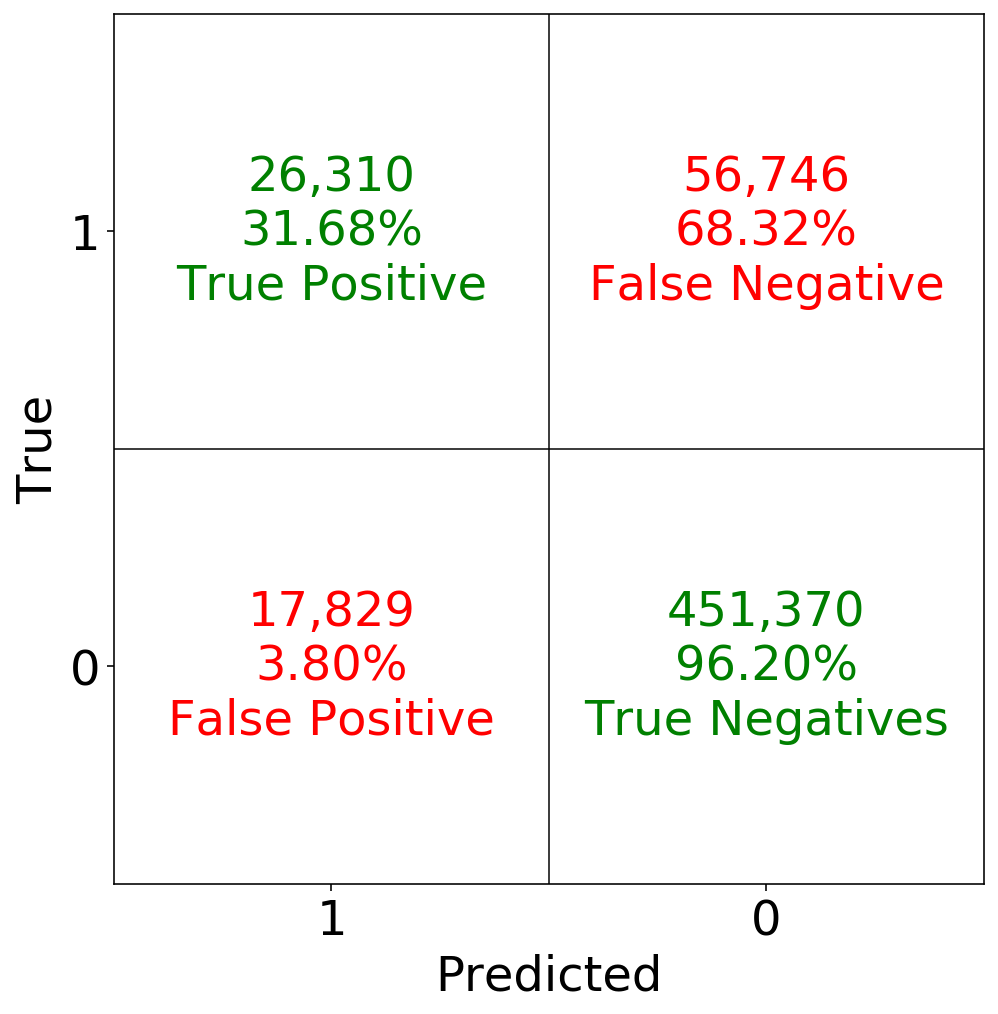

In [10]:
conf_mat = confusion_matrix(
    [1 if x > POSITIVE_ABOVE  else 0 for x in y_nz],
    [1 if x > POSITIVE_ABOVE  else 0 for x in y_hat_nz],  
    labels=[1,0])

conf_mat_p = np.round(conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis],4)*100
log["true_positive"]=f"{conf_mat_p[0,0]:.2f}%"
log["false_negative"]=f"{conf_mat_p[0,1]:.2f}%"
log["false_positive"]=f"{conf_mat_p[1,0]:.2f}%"
log["true_negative"]=f"{conf_mat_p[1,1]:.2f}%"

precision = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0])
recall = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
log["precision"]=precision
log["recall"]=recall
log["F1"] = (2*precision*recall)/(precision+recall)

descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
colors = np.array([["green", "red"], ["red", "green"]])

plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
for i, j in itertools.product(range(conf_mat_p.shape[0]), range(conf_mat_p.shape[1])): 
    plt.text(j, i,
             format(conf_mat[i, j], ",")+'\n'+
             format(conf_mat_p[i, j], ".2f")+'%\n'+
             descriptions[i, j], horizontalalignment="center", verticalalignment="center",
             color=colors[i,j])
plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
plt.ylabel('True')
plt.xlabel('Predicted')
# plt.title("Confusion Matrix")
plt.xticks([0,1], [1,0])
plt.yticks([0,1], [1,0])
plt.show()

In [11]:
log

mse              0.068137
rmse             0.261031
mae              0.175807
r-squared        0.035398
exp_var          0.035484
true_positive      31.68%
false_negative     68.32%
false_positive      3.80%
true_negative      96.20%
precision        0.596072
recall           0.316774
F1               0.413696
dtype: object

In [12]:
print(f"Elapsed time: {time.time()-start_time:.2f} seconds")

Elapsed time: 1.10 seconds


In [13]:
log.to_csv(TEST_RESULTS_PATH, index = True, header=False)